# Calculating drainage area with `DAGGER`

In this notebook, we are illustrating different ways to calculate drainage area using the python wrapper of `DAGGER`. We explore the differences between single flow and multiple flow on a small DEM as well as how to weight drainage area spatially in order to simulate the effect of spatially variable precipitations.


## Setup

**Requirements: install the dependencies listed in the readme of the example folder**

First, let's import the relevant packages:
- `dagger` of course
- `helper` is a small local script (`helper.py`) using `rasterio/GDAL` to load DEMs
- `matplotlib` for the visualization
- `numpy` to manage arrays/matrix operations

In [1]:
import dagger as dag
from helper import load_raster
import matplotlib.pyplot as plt
import numpy as np

# The following line is a jupyter lab command telling it to use the interactive widget ipympl for matplotlib
%matplotlib widget

## Loading and preprocessing the DEM

`load_raster` is a simple function loading the input file into a dictionary with all the infos about the raster (dx,dy,nx,ny,...) as well as the array data. Preprocessing is done while computing the graph and ensure the local minima are solved and flow is not stopped midway through the DEM. For more detailed example about flow preprocessing, see the dedicated notebook.

In the following cell, we create the main objects required for `DAGGER` to work: 
- `con` is a `D8N` (D8 neighbours) and manages all the connections between nodes in the 8 directions (see dedicated notebook for more details)
- `gf` is the `graph` managing the graph operations
- `PPdem` is a numpy array storing the topography preprocessed after local minima solvers
- `HS` is the hillshaded relief for visualisation (numpy array between 0 and 1 simulating an approx shading)


In [23]:
dem = load_raster("example.tif")
dem["array"] += np.random.rand(*dem["array"].shape) * 20

con = dag.D8N(dem["nx"], dem["ny"], dem["dx"], dem["dy"], dem["x_min"], dem["y_min"])
gf = dag.graph(dem["nx"] * dem["ny"], 8)
gf.init_graph(con)
gf.set_LMR_method(dag.LMR.none)
PPdem = gf.compute_graph(dem['array'].ravel(), con, False, True)
HS = dag.hillshade(con,PPdem)
rshp = [dem['ny'], dem['nx']]
rshp

[522, 603]

## let's first visualize our DEM

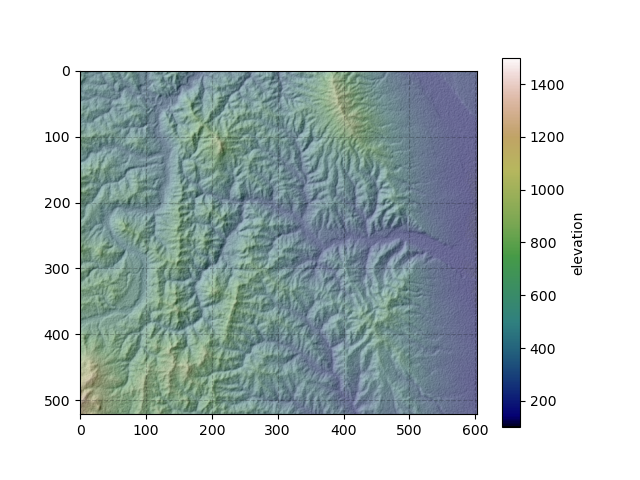

In [24]:
fig, ax = plt.subplots()
cb = ax.imshow(PPdem.reshape(rshp), cmap = 'gist_earth', vmin =100, vmax = 1500)
ax.imshow(HS.reshape(rshp), cmap = 'gray', alpha = 0.6)
plt.colorbar(cb, label = "elevation")
ax.grid(ls = '--', alpha = 0.2, color = 'k')

## Calculating drainage area

The drainage area is in all points of the DEM the upstream surface draining to a given node. This can be calculated in different ways, but by far the most efficient consists in traversing the topographic graph from the most _upstream_ node to the most _downstream_ ones, each time transmitting the current value to the node receivers. In other word:

\begin{equation}
A(x) = \int_{upstream}^{x}CellArea dx
\end{equation}

and in discretised term:
\begin{equation}
Ai = \sum_{upstream}^{x} CellArea
\end{equation}

### Steepest descent

The simplest way to calculate drainage area is to follow the steepest descent route: each nodes' area is fully transmitted to the receivers with the steepest slope.

pros:
- faster
- simpler
- generate flow linesm easily translatable to river paths

cons:
- Only one possible route, which might misrepresent flow routing on hillslopes, low-relief areas and depression
- "artificial" aspect
- assume that a cell contains all the drainage, which can be difficult to justify for high-res studies


The calculation is simple with `DAGGER` and only requires the single flow graph top be computed. We use the `accumulate_constant_downstream_SFD` to calculate it, which, as the name suggests, accumulate a constant value from the upstream nodes to the downstream ones which is exactly what drainage area is.

In [25]:
SDA = gf.accumulate_constant_downstream_SFD(con,dem['dx'] * dem['dy'])

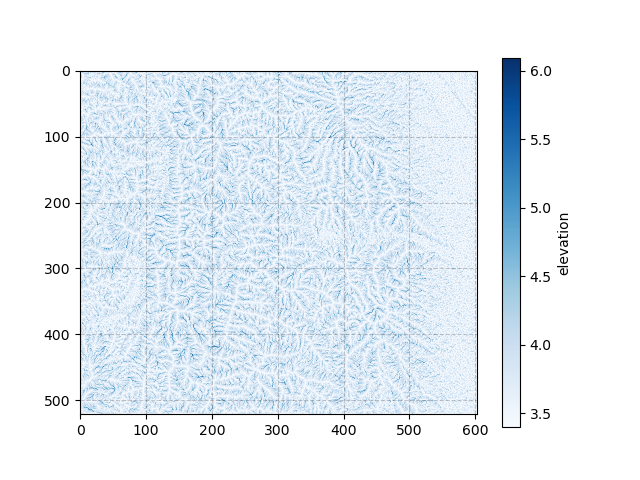

In [26]:
fig, ax = plt.subplots()
cb = ax.imshow(np.log10(SDA).reshape(rshp), cmap = 'Blues')
# cb = ax.imshow(SDA.reshape(rshp), cmap = 'Blues')
# ax.imshow(HS.reshape(rshp), cmap = 'gray', alpha = 0.1)
plt.colorbar(cb, label = "elevation")
ax.grid(ls = '--', alpha = 0.2, color = 'k')

## Calculating drainage area with Multiple Flow direction

Multiple flow direction is less straighforward, we need to determine a weighing factor splitting the drainage area to multiple receivers. 

pros:
- more realistic flow-based drainage area
- fits high resolution DEM
- prettier

cons:
- flow lines are multiple pixels wide and harder to process
- more parameters to constrain


This asks intermediates functionsto calculates this. `Dagger` offers a general way to calculate weight function of the slope to each receivers to the power `p`:

\begin{equation}
w_i = \frac{S_r^p}{\sum_{rec} S_r^p}
\end{equation}

It allows fine grained control on the influence of slope in the process of splitting flux. 

Let's first calculate the gradient for each links. The function `get_links_gradient` takes the connector and the topography to return an array of `n_links` size calculating gradient function of an input topography and the current graph. (see the notebook about node/link indicies if needed)

In [6]:
gradient = gf.get_links_gradient(con, PPdem)

We are now ready to calculate the MFD drainage area. The main parameter to worry about is `p`. It is not the aim of `dagger` to suggest a value over another as this is case/use dependent so we will focus on the tool we provide here and illustrate the effect of varying p. Higher `p` means more flow follow the steepest descent direction.

We start `p = 0`, which basically means that the slope has no influence and flow will go to all the downslope receivers in equal proportions.

In [7]:
weights = gf.get_link_weights(gradient,0)
MFA_0 = gf.accumulate_constant_downstream_MFD(con,weights,1)

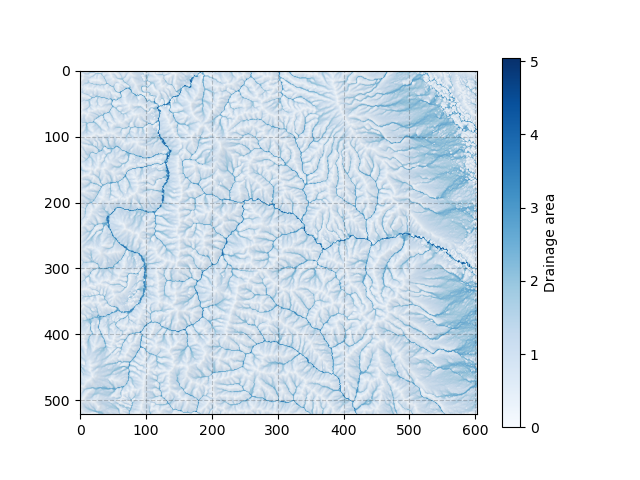

In [8]:
fig, ax = plt.subplots()
cb = ax.imshow(np.log10(MFA_0).reshape(rshp), cmap = 'Blues')
ax.imshow(HS.reshape(rshp), cmap = 'gray', alpha = 0.1)
plt.colorbar(cb, label = "Drainage area")
ax.grid(ls = '--', alpha = 0.2, color = 'k')

This is the most divergent scenario and may be rarely relevant for drainage area but it illustrates well the differences of pattern with single flow direction. If you zoom on the river with the square zoom option (only feasible with %matplotlib widget active, you'll notice they are multiple pixel wide (this is a low0res DEM, it would be more obvious on a lidar but bigger to distribute as test site). The hillslopes in the eastern part of thhis landscape are also a good exemple: they are very linear and you see that the flow struggle to converge and form channels.

OK now let's consider the partition to be function of the squareroot of the slope, this would be in accordance with mannings equations for example.


In [12]:
weights = gf.get_link_weights(gradient,0.05)
MFA_05 = gf.accumulate_constant_downstream_MFD(con,weights,900)

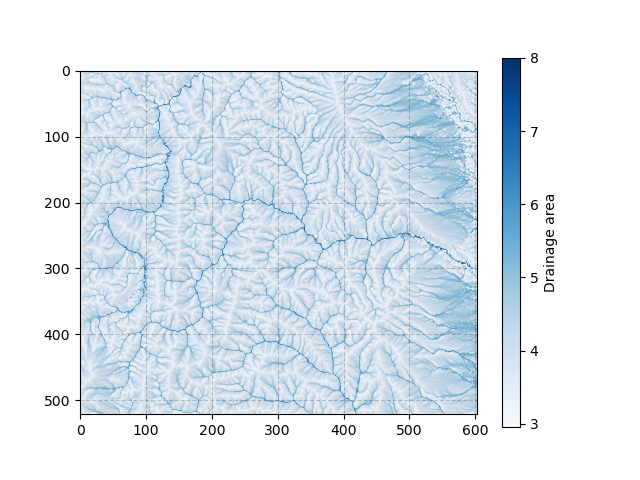

In [13]:
fig, ax = plt.subplots()
cb = ax.imshow(np.log10(MFA_05).reshape(rshp), cmap = 'Blues')
ax.imshow(HS.reshape(rshp), cmap = 'gray', alpha = 0.1)
plt.colorbar(cb, label = "Drainage area")
ax.grid(ls = '--', alpha = 0.2, color = 'k')